Homework 2:

Q1：

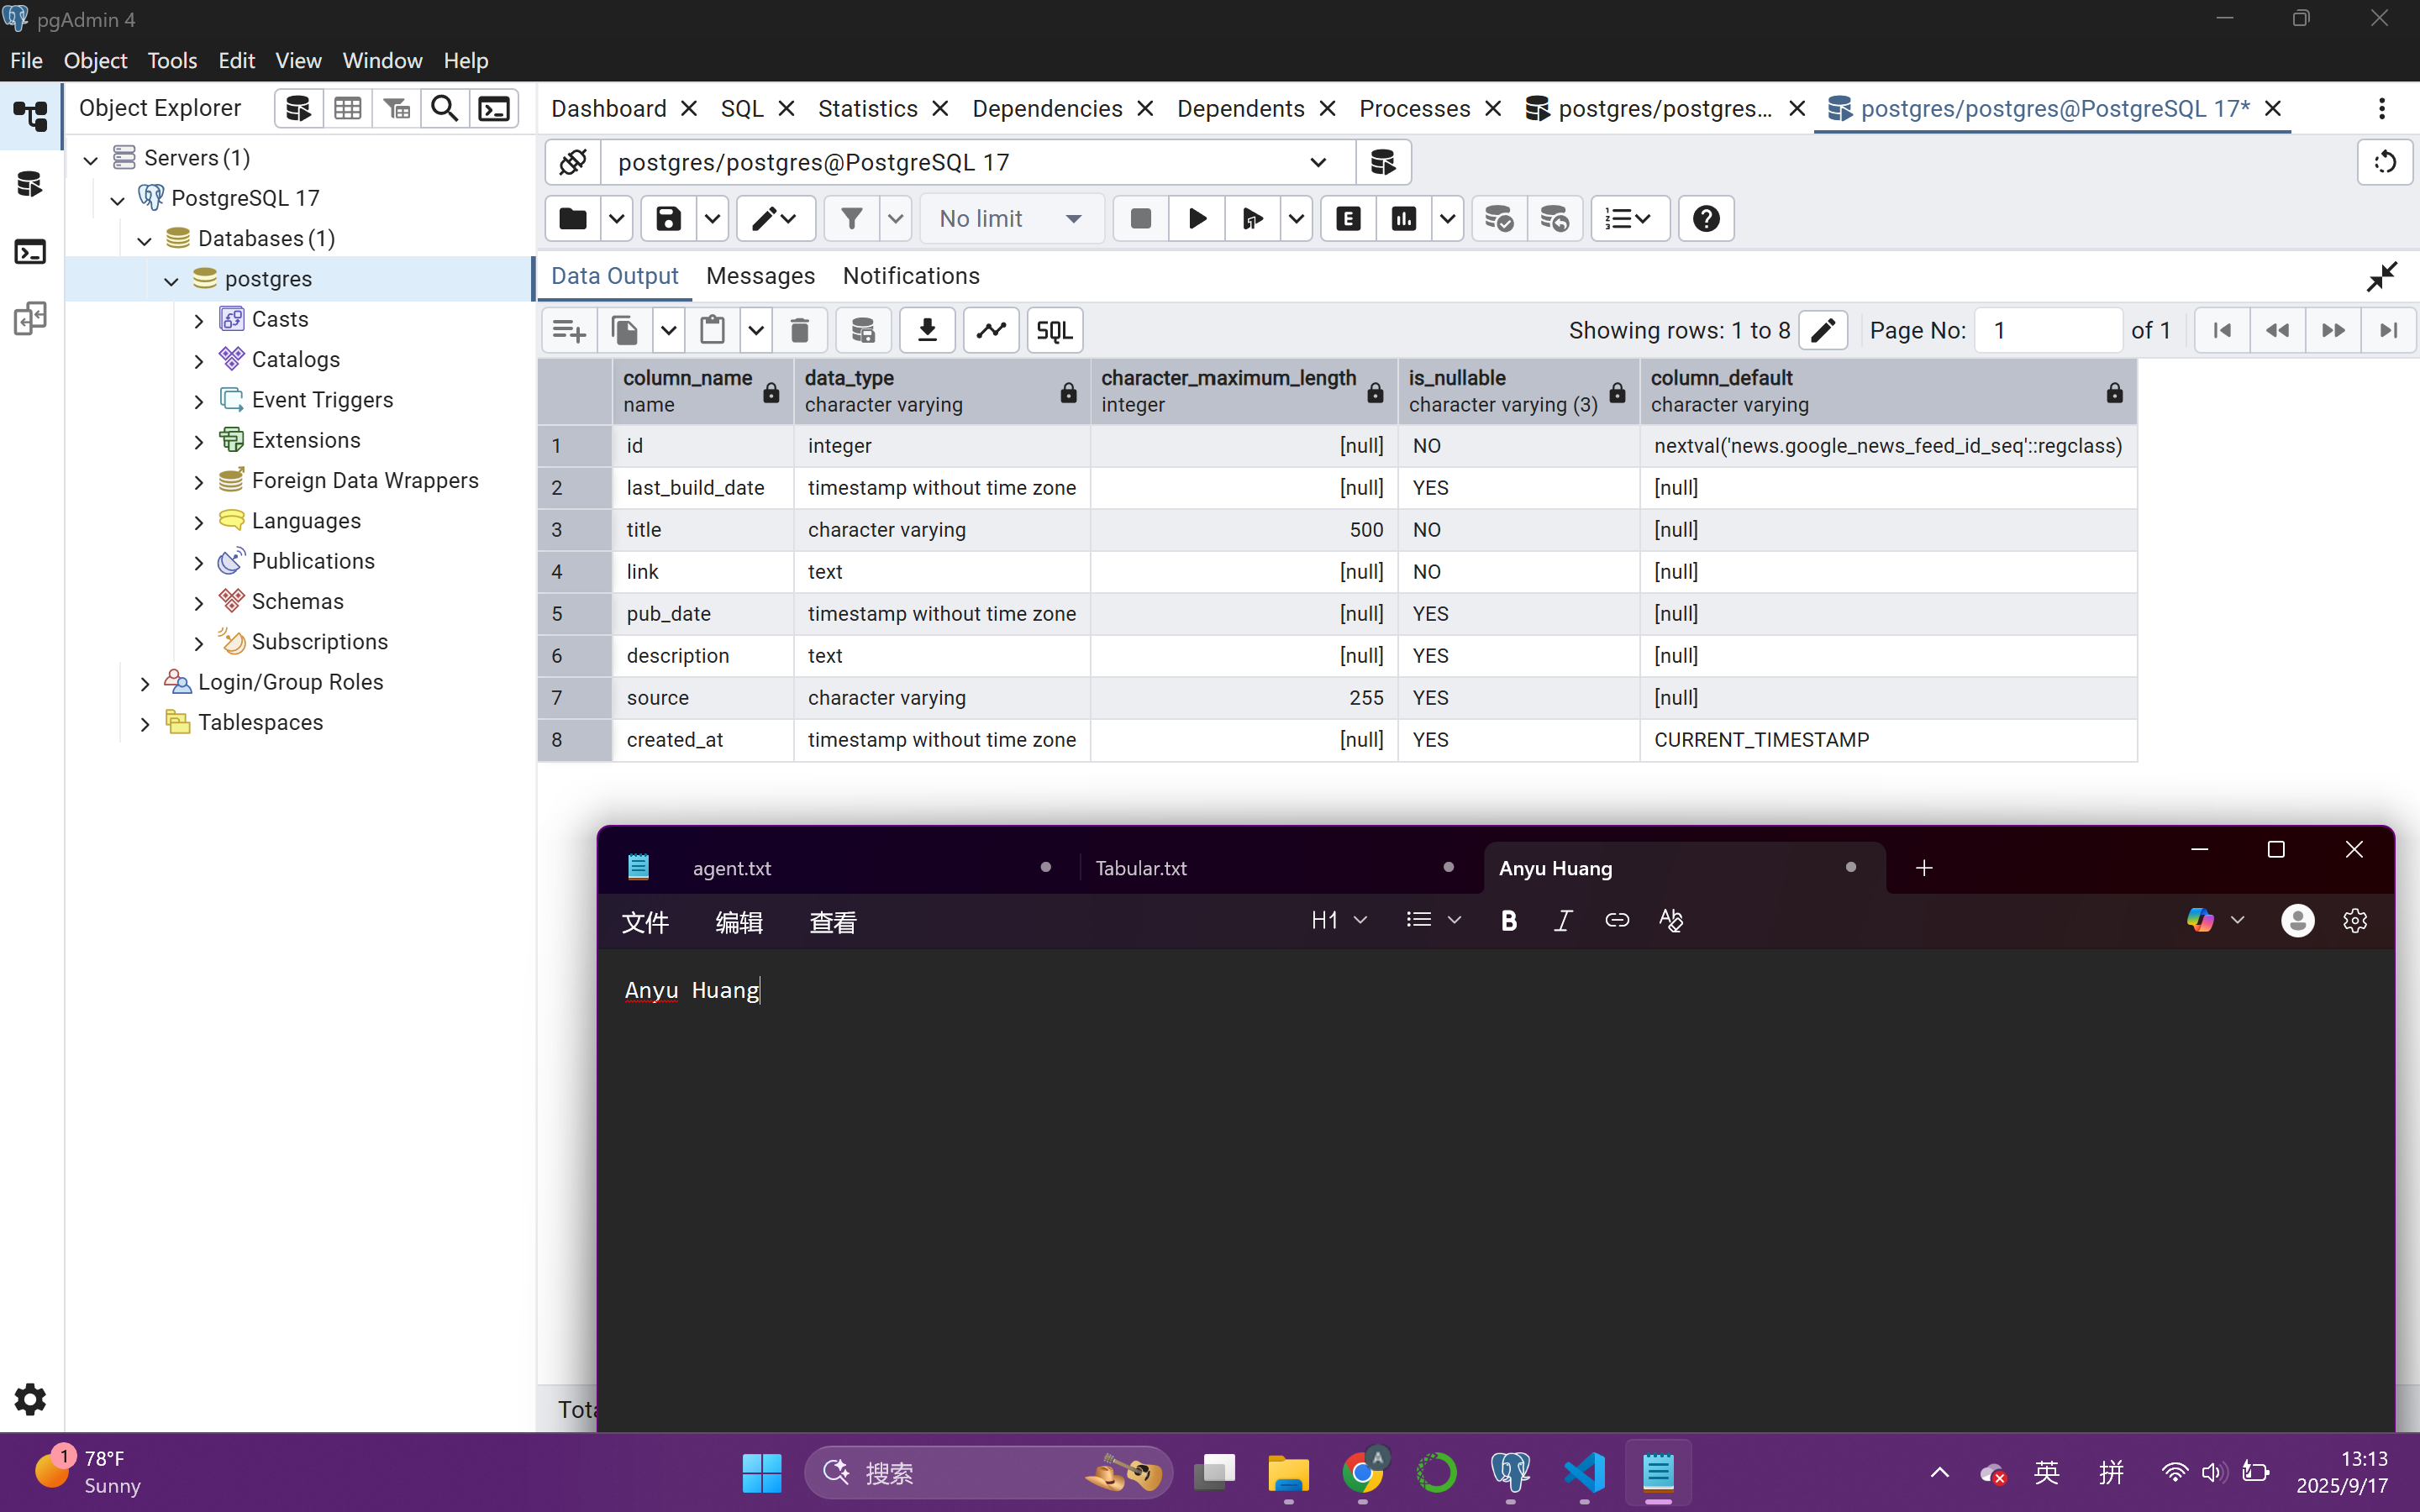

Q2:

In [ ]:

import feedparser
import psycopg2
from psycopg2.extras import execute_batch
from dateutil import parser
import re


def populate_news_table():
    """Populate the news table with RSS feed data"""

    DB_HOST = "localhost"
    DB_PORT = "5432"
    DB_NAME = "postgres"
    DB_USER = "postgres"
    DB_PASSWORD = "848651"
    rss_url = "https://news.google.com/rss/search?q=technology&hl=en-US&gl=US&ceid=US:en"
    feed = feedparser.parse(rss_url)


    last_build_date = None
    if 'updated' in feed.feed:
        last_build_date = parser.parse(feed.feed.updated)
    news_data = []

    for entry in feed.entries:
        source = ''
        if 'source' in entry:
            source_data = entry.source
            if hasattr(source_data, 'title'):
                source = source_data.title
            else:
                # Extract text only, remove URLs
                source_text = str(source_data)
                source = source_text.split('https://')[0].strip()
                source = re.sub('<[^<]+?>', '', source).strip()

        pub_date = None
        if 'published' in entry:
            pub_date = parser.parse(entry.published)

        news_data.append((
            last_build_date,
            entry.get('title', '')[:500],
            entry.get('link', ''),
            pub_date,
            entry.get('description', ''),
            source[:255]
        ))

    print(f"Parsed {len(news_data)} news items")

    
    try:
        conn = psycopg2.connect(
            host=DB_HOST,
            port=DB_PORT,
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD
        )

        cur = conn.cursor()

        insert_query = """
                       INSERT INTO news.google_news_feed
                           (last_build_date, title, link, pub_date, description, source)
                       VALUES (%s, %s, %s, %s, %s, %s) ON CONFLICT (link) DO \
                       UPDATE \
                           SET \
                               last_build_date = EXCLUDED.last_build_date, \
                           title = EXCLUDED.title, \
                           pub_date = EXCLUDED.pub_date, \
                           description = EXCLUDED.description, \
                           source = EXCLUDED.source; \
                       """


        execute_batch(cur, insert_query, news_data, page_size=100)

        conn.commit()

        # Get count of records
        cur.execute("SELECT COUNT(*) FROM news.google_news_feed")
        total = cur.fetchone()[0]

        print(f"Successfully populated table!")
        print(f"Total records in table: {total}")

        cur.close()
        conn.close()
        return True

    except Exception as e:
        print(f"Error: {e}")
        if 'conn' in locals():
            conn.rollback()
            conn.close()
        return False



if populate_news_table():
    print("\nTable populated successfully")

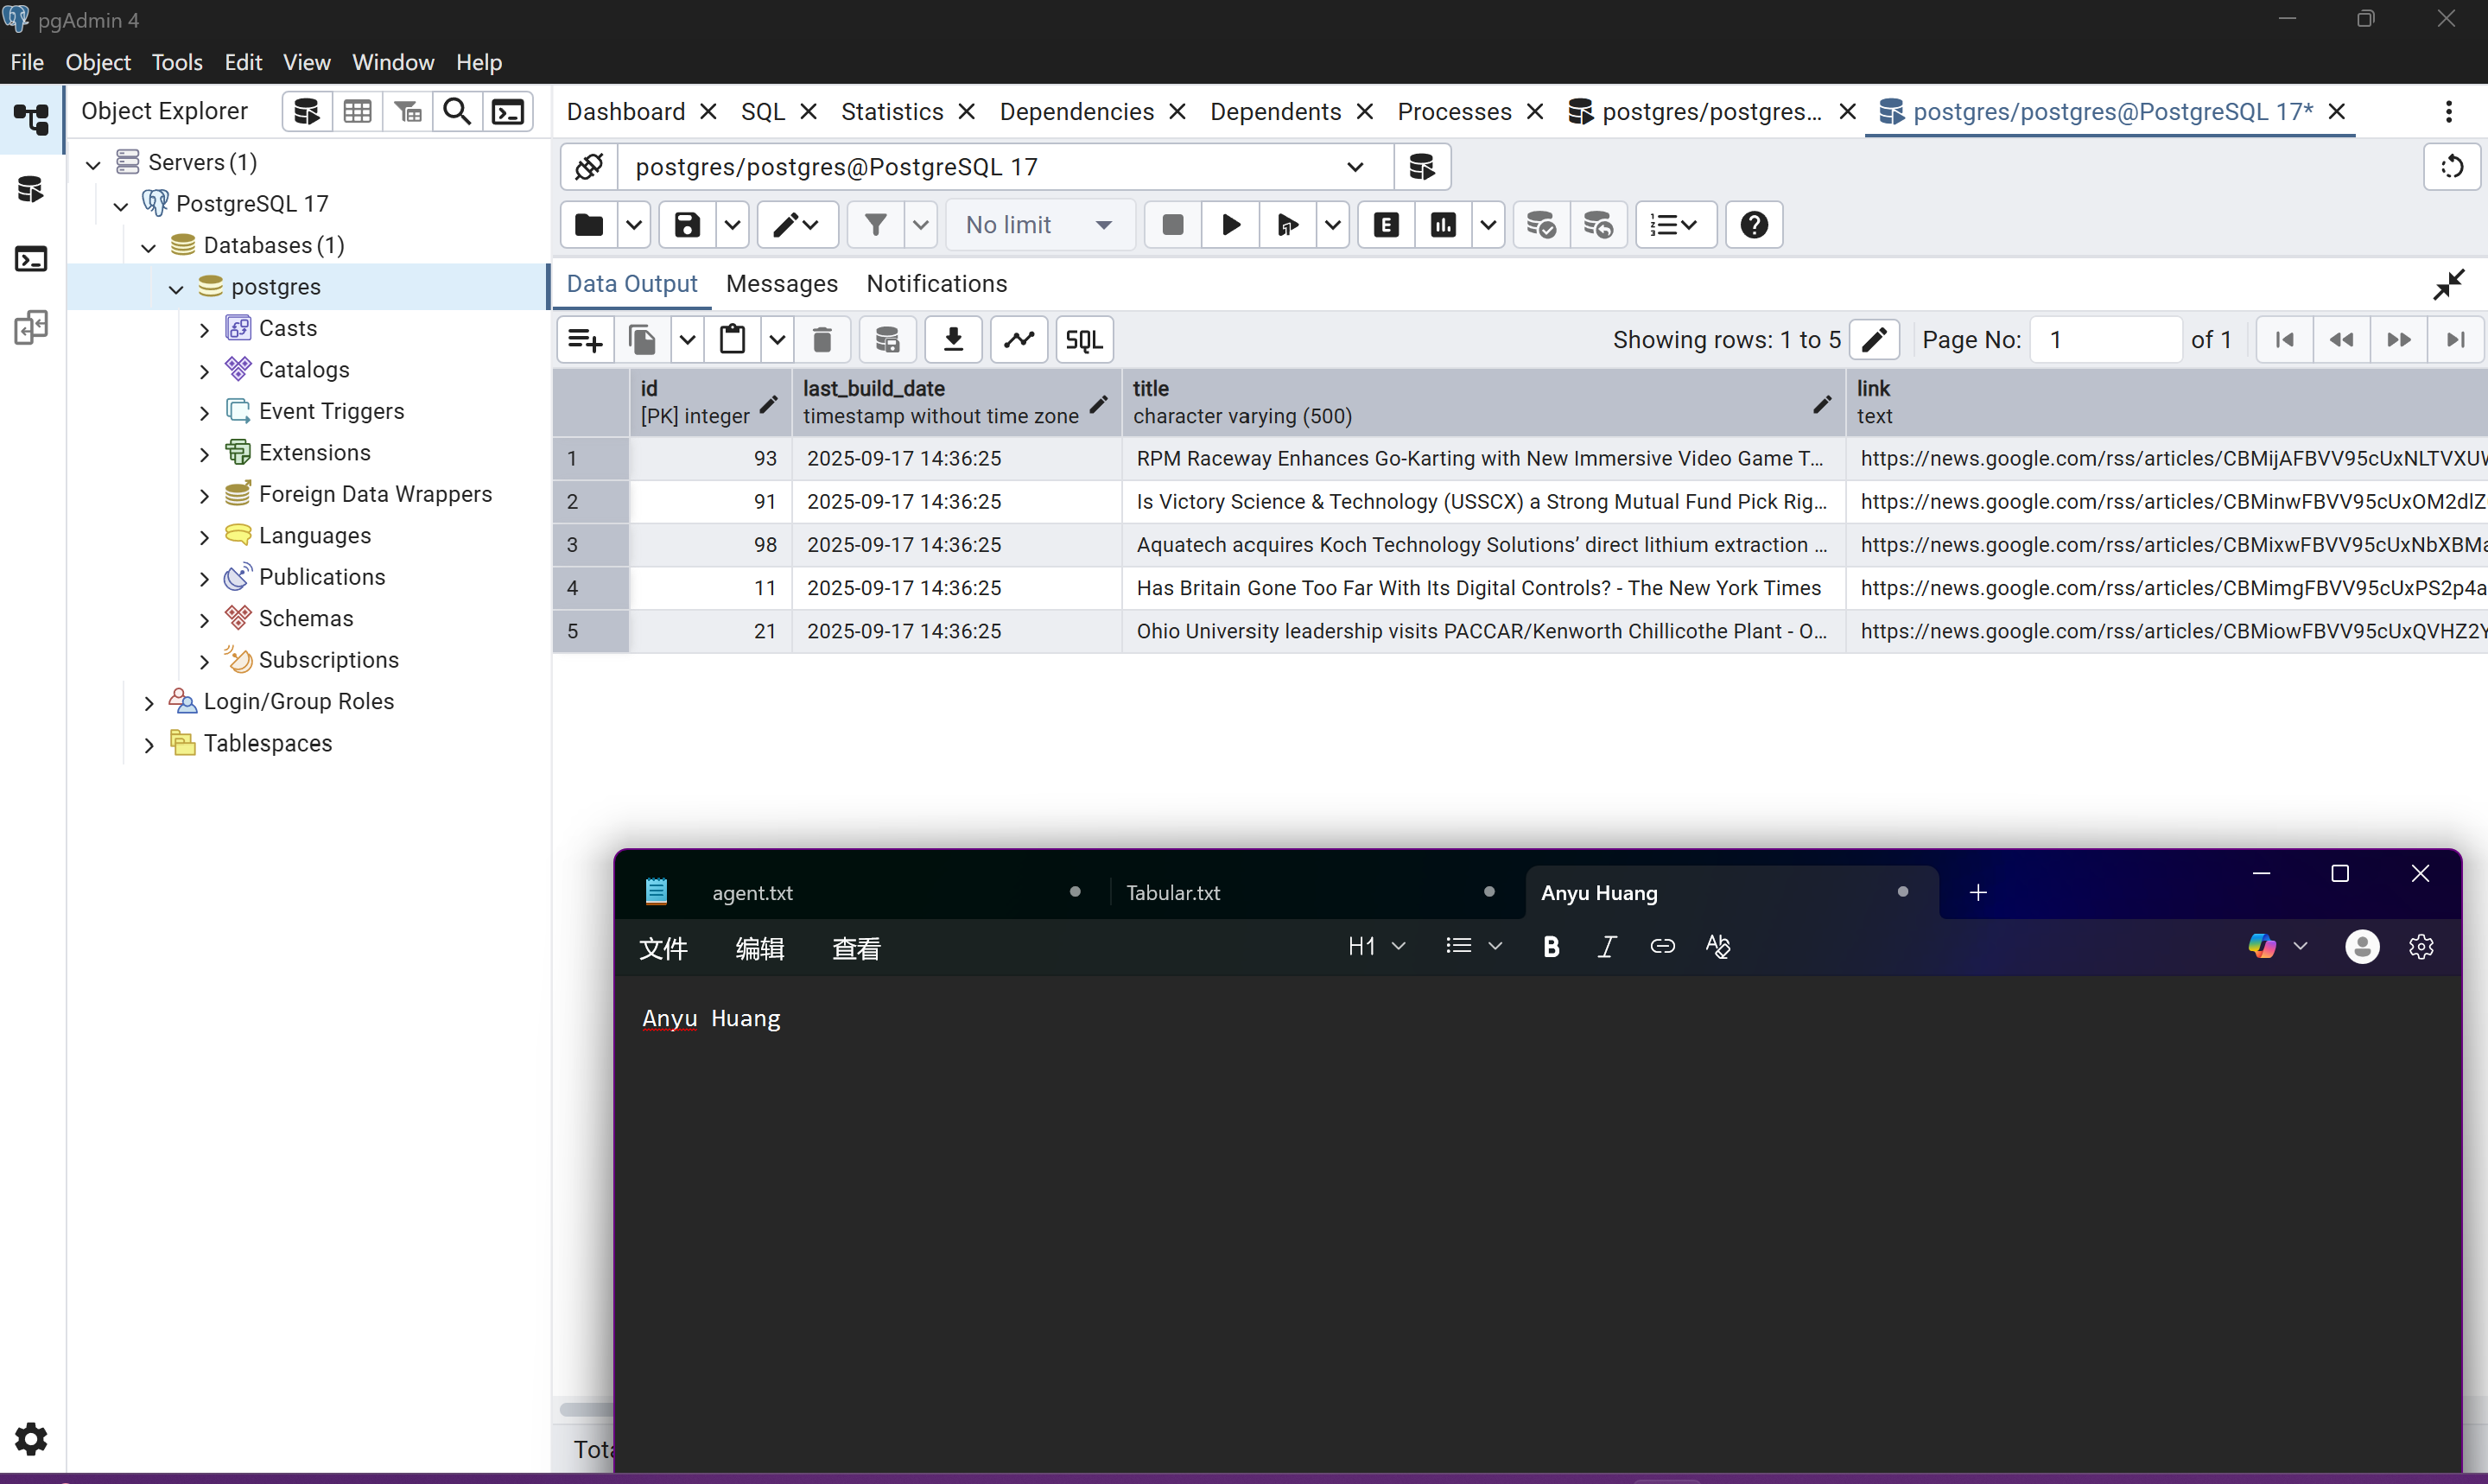

Q3

In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession, functions as F, types as T

# --- Spark session ---
spark = (
    SparkSession.builder
    .appName("NewsLast24Hours")
    .master("local[*]")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.sql.session.timeZone", "UTC")
    .config("spark.jars", r"C:\spark\jars\postgresql-42.7.7.jar")  # your jar path
    .getOrCreate()
)

JDBC_URL = "jdbc:postgresql://localhost:5432/postgres"
DB       = {"user": "postgres", "password": "848651", "driver": "org.postgresql.Driver"}
TABLE    = "news.google_news_feed"

def _pick(cols, *names):
    m = {c.lower(): c for c in cols}
    for n in names:
        if n and n.lower() in m:
            return m[n.lower()]
    return None

def _as_ts(c): 
    return F.col(c).cast(T.TimestampType())

df = spark.read.jdbc(url=JDBC_URL, table=TABLE, properties=DB)

ts_cols = [_pick(df.columns, "pub_date"),
           _pick(df.columns, "created_at"),
           _pick(df.columns, "last_build_date")]
ts_cols = [c for c in ts_cols if c]
if not ts_cols:
    raise ValueError("No timestamp-like column found (pub_date/created_at/last_build_date).")

df = df.withColumn("pub_ts", F.coalesce(*[_as_ts(c) for c in ts_cols]))

cutoff_ts = F.to_timestamp(
    F.from_unixtime(F.unix_timestamp(F.current_timestamp()) - F.lit(24 * 3600))
)

recent = (df.where(F.col("pub_ts").isNotNull() & (F.col("pub_ts") >= cutoff_ts))
            .orderBy(F.col("pub_ts").desc()))

title  = _pick(recent.columns, "title")
source = _pick(recent.columns, "source")
link   = _pick(recent.columns, "link")

cols = []
if title:  cols.append(F.col(title).alias("title"))
if source: cols.append(F.col(source).alias("source"))
cols += [F.col("pub_ts")]
if link:   cols.append(F.col(link).alias("link"))

out = recent.select(*cols) if cols else recent.select("pub_ts")

# This part is just for the demonstrate, since there is no more NEWS while I testing the code
if n == 0:
    print("\n[Demo] No rows in 24h; widening to 168h just to demonstrate output.")
    res_demo = find_news_last_hours(168) 
    n_demo = res_demo.count()
    print(f"[DIAG] total={res_demo.count()}  "
          f"min={res_demo.agg(F.min('pub_ts')).first()[0]}  "
          f"max={res_demo.agg(F.max('pub_ts')).first()[0]}  (window=168h)")
    print(f"Total articles from last 168 hours: {n_demo}")
    res_demo.show(min(n_demo, 50), truncate=False) 
# --- END ADD ---



count = out.count()
print(f"\nTotal articles from last 24 hours: {count}")
out.show(count if count <= 200 else 200, truncate=False)

spark.stop()



[Demo] No rows in 24h; widening to 168h just to demonstrate output.
[DIAG] total=102  min=2025-09-14 07:00:00  max=2025-09-17 14:24:03  (window=168h)
[DIAG] total=102  min=2025-09-14 07:00:00  max=2025-09-17 14:24:03  (window=168h)
Total articles from last 168 hours: 102
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

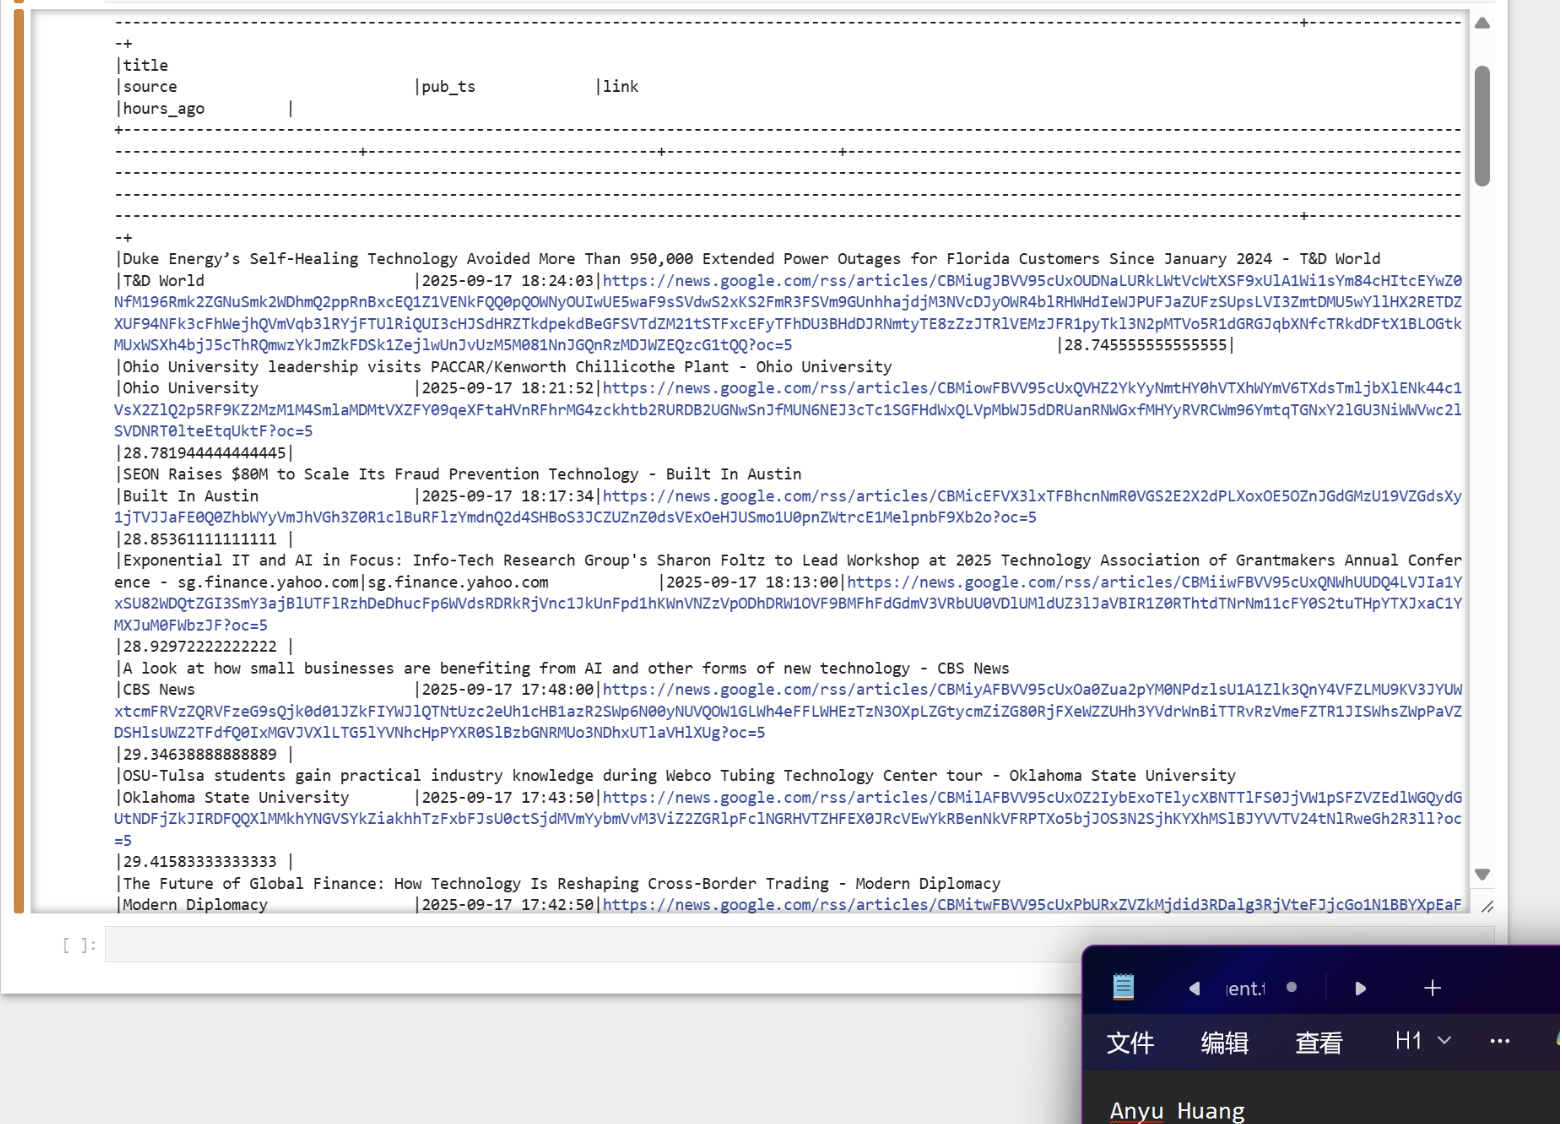

Q4:

In [ ]:

import os
import re
import xml.etree.ElementTree as ET
from datetime import datetime, timezone

import feedparser
import psycopg2
from psycopg2.extras import execute_batch
from dateutil import parser as dtparse


DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASSWORD = "848651"

TABLE = "news.google_news_feed"
XML_OUTFILE = "p4_last_24h.xml"

FEEDS = {
    "technology": "https://news.google.com/rss/search?q=technology&hl=en-US&gl=US&ceid=US:en",
    "business":   "https://news.google.com/rss/search?q=business&hl=en-US&gl=US&ceid=US:en",
    "sports":     "https://news.google.com/rss/search?q=sports&hl=en-US&gl=US&ceid=US:en",
}

def ensure_schema_and_table(cur):
    """Create schema/table + category column + helpful indexes."""
    cur.execute("""
        CREATE SCHEMA IF NOT EXISTS news;

        CREATE TABLE IF NOT EXISTS news.google_news_feed (
            id               SERIAL PRIMARY KEY,
            last_build_date  TIMESTAMP NULL,
            title            TEXT,
            link             TEXT UNIQUE,
            pub_date         TIMESTAMP NULL,
            description      TEXT,
            source           VARCHAR(255),
            category         VARCHAR(50),
            created_at       TIMESTAMP NOT NULL DEFAULT NOW()
        );

        CREATE INDEX IF NOT EXISTS idx_gnews_pub_date ON news.google_news_feed (pub_date DESC);
        CREATE INDEX IF NOT EXISTS idx_gnews_category ON news.google_news_feed (category);
    """)


def parse_feed(url: str):
    """Parse RSS into list of items (dicts)."""
    feed = feedparser.parse(url)

    last_build_date = None
    if "updated" in feed.feed:
        try:
            last_build_date = dtparse.parse(feed.feed.updated)
        except Exception:
            last_build_date = None

    items = []
    for e in feed.entries:
        # source text only
        source = ""
        if "source" in e:
            src = e.source
            if hasattr(src, "title") and src.title:
                source = src.title
            else:
                sraw = re.sub(r"<[^>]+>", "", str(src))
                source = sraw.split("https://")[0].strip()

        pub_date = None
        if "published" in e:
            try:
                pub_date = dtparse.parse(e.published)
            except Exception:
                pub_date = None

        items.append({
            "last_build": last_build_date,
            "title":       e.get("title", "")[:500],
            "link":        e.get("link", ""),
            "pub_date":    pub_date,
            "description": e.get("description", ""),
            "source":      (source or "")[:255],
        })
    return items


def overwrite_all_rows(cur, rows):
    """
    Overwrite target table atomically using a TEMP staging table.
    rows = list of tuples matching target columns.
    """
    cur.execute("""
        CREATE TEMP TABLE gnews_stage (
            last_build_date TIMESTAMP NULL,
            title           TEXT,
            link            TEXT,
            pub_date        TIMESTAMP NULL,
            description     TEXT,
            source          VARCHAR(255),
            category        VARCHAR(50)
        ) ON COMMIT DROP;
    """)

    execute_batch(
        cur,
        """INSERT INTO gnews_stage
           (last_build_date, title, link, pub_date, description, source, category)
           VALUES (%s,%s,%s,%s,%s,%s,%s)""",
        rows,
        page_size=200
    )

    cur.execute("TRUNCATE TABLE news.google_news_feed;")
    cur.execute("""
        INSERT INTO news.google_news_feed
            (last_build_date, title, link, pub_date, description, source, category)
        SELECT last_build_date, title, link, pub_date, description, source, category
        FROM gnews_stage;
    """)


def export_last_24h_to_xml(cur, outfile: str):
    """Write last-24h rows to an XML file."""
    cur.execute("""
        SELECT title, source, category, link, pub_date
        FROM news.google_news_feed
        WHERE pub_date IS NOT NULL
          AND pub_date >= NOW() - INTERVAL '24 hours'
        ORDER BY pub_date DESC;
    """)
    rows = cur.fetchall()

    root = ET.Element("news", attrib={
        "generated_at": datetime.now(timezone.utc).isoformat(timespec="seconds"),
        "window": "last_24h_UTC",
        "count": str(len(rows)),
    })

    for title, source, category, link, pub_date in rows:
        item = ET.SubElement(root, "item")
        if title:    ET.SubElement(item, "title").text    = title
        if source:   ET.SubElement(item, "source").text   = source
        if category: ET.SubElement(item, "category").text = category
        if link:     ET.SubElement(item, "link").text     = link
        ET.SubElement(item, "pub_date").text = (
            pub_date.strftime("%Y-%m-%d %H:%M:%S") if pub_date else ""
        )

  
    def _indent(elem, level=0):
        i = "\n" + level * "  "
        if len(elem):
            if not elem.text or not elem.text.strip():
                elem.text = i + "  "
            for child in elem:
                _indent(child, level + 1)
            if not child.tail or not child.tail.strip():
                child.tail = i
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i

    _indent(root)
    ET.ElementTree(root).write(outfile, encoding="utf-8", xml_declaration=True)


def main():
    print("Question 4: categories + overwrite + XML export\n")


    rows = []
    total_items = 0
    for cat, url in FEEDS.items():
        print(f"Fetching {cat} feed...")
        items = parse_feed(url)
        total_items += len(items)
        for it in items:
            rows.append((
                it["last_build"],      # last_build_date
                it["title"],           # title
                it["link"],            # link
                it["pub_date"],        # pub_date
                it["description"],     # description
                it["source"],          # source
                cat                    # category
            ))
    print(f"Parsed total items: {total_items}")

    try:
        conn = psycopg2.connect(
            host=DB_HOST, port=DB_PORT, dbname=DB_NAME,
            user=DB_USER, password=DB_PASSWORD
        )
        cur = conn.cursor()

        ensure_schema_and_table(cur)

        if rows:
            overwrite_all_rows(cur, rows)
            conn.commit()
            print(f"Overwrote table with {len(rows)} rows in {TABLE}")
        else:
            print("No rows to write; table left unchanged.")
 
        cur.execute(f"SELECT COUNT(*) FROM {TABLE};")
        total = cur.fetchone()[0]
        print(f"Total records in table now: {total}")

        export_last_24h_to_xml(cur, XML_OUTFILE)
        print(f"\n✓ Wrote XML: {os.path.abspath(XML_OUTFILE)}")

        cur.close()
        conn.close()

    except Exception as e:
        print(f"Error: {e}")
        try:
            conn.rollback()
            conn.close()
        except Exception:
            pass


if __name__ == "__main__":
    main()


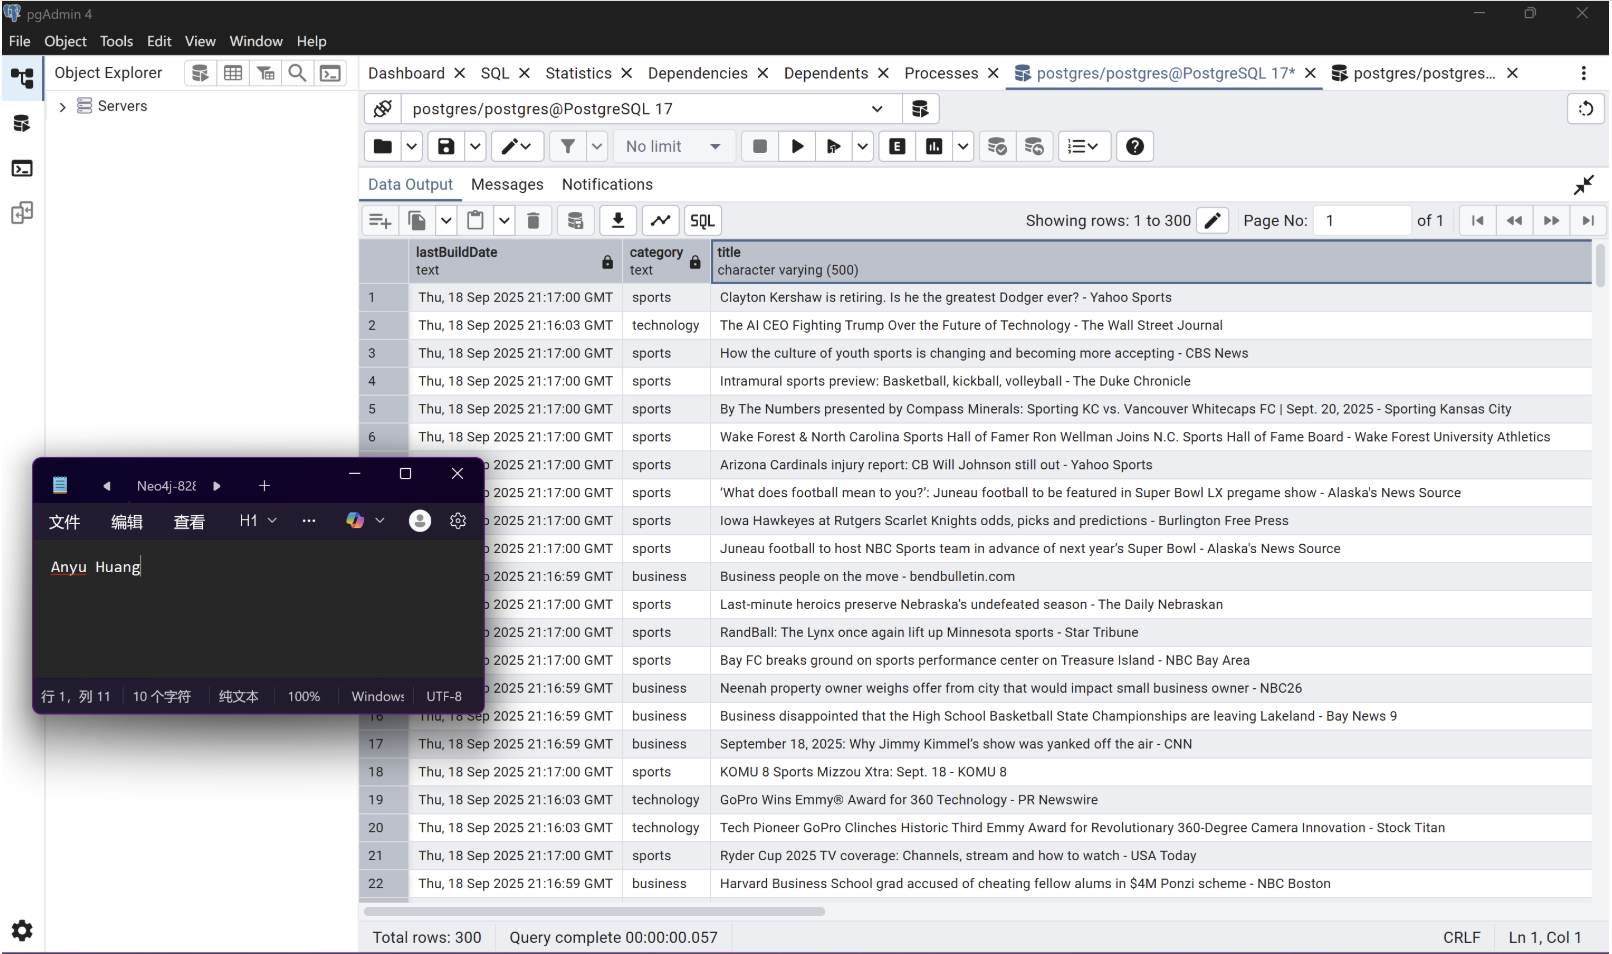

Q5：

In [ ]:
import psycopg2

DB = dict(
    host="localhost",
    port="5432",
    dbname="postgres",
    user="postgres",
    password="848651",
)

TABLE = "news.google_news_feed"
BATCH = 10_000

DDL_SETUP = f"""
CREATE EXTENSION IF NOT EXISTS pg_trgm;

-- Speeds up ILIKE '%%NFL%%' massively
CREATE INDEX IF NOT EXISTS idx_gnews_title_trgm
  ON {TABLE} USING GIN (title gin_trgm_ops);
"""

COUNT_NFL = f"""
SELECT COUNT(*) FROM {TABLE}
WHERE title ILIKE '%%NFL%%';
"""


DELETE_BATCH = f"""
WITH victims AS (
  SELECT id
  FROM {TABLE}
  WHERE title ILIKE '%%NFL%%'
  LIMIT {BATCH}
)
DELETE FROM {TABLE} t
USING victims v
WHERE t.id = v.id
RETURNING t.id;
"""

VERIFY_SAMPLE = f"""
SELECT id, category, pub_date, title
FROM {TABLE}
WHERE title ILIKE '%%NFL%%'
ORDER BY pub_date DESC NULLS LAST, id DESC
LIMIT 20;
"""


def main():
    conn = psycopg2.connect(**DB)
    conn.autocommit = False
    cur = conn.cursor()
    cur.execute(DDL_SETUP)
    conn.commit()

    cur.execute(COUNT_NFL)
    before = cur.fetchone()[0]
    print(f"Matches BEFORE delete: {before}")

    total_deleted = 0
    while True:
        cur.execute(DELETE_BATCH)
        deleted_ids = cur.fetchall()  # list of (id,) rows
        batch_deleted = len(deleted_ids)
        total_deleted += batch_deleted
        conn.commit()
        if batch_deleted == 0:
            break
        print(f"  - deleted {batch_deleted} rows this batch (total {total_deleted})")

    cur.execute(COUNT_NFL)
    after = cur.fetchone()[0]
    print(f"\nMatches AFTER delete: {after}")

    print(VERIFY_SAMPLE.strip())

    cur.close()
    conn.close()


if __name__ == "__main__":
    main()



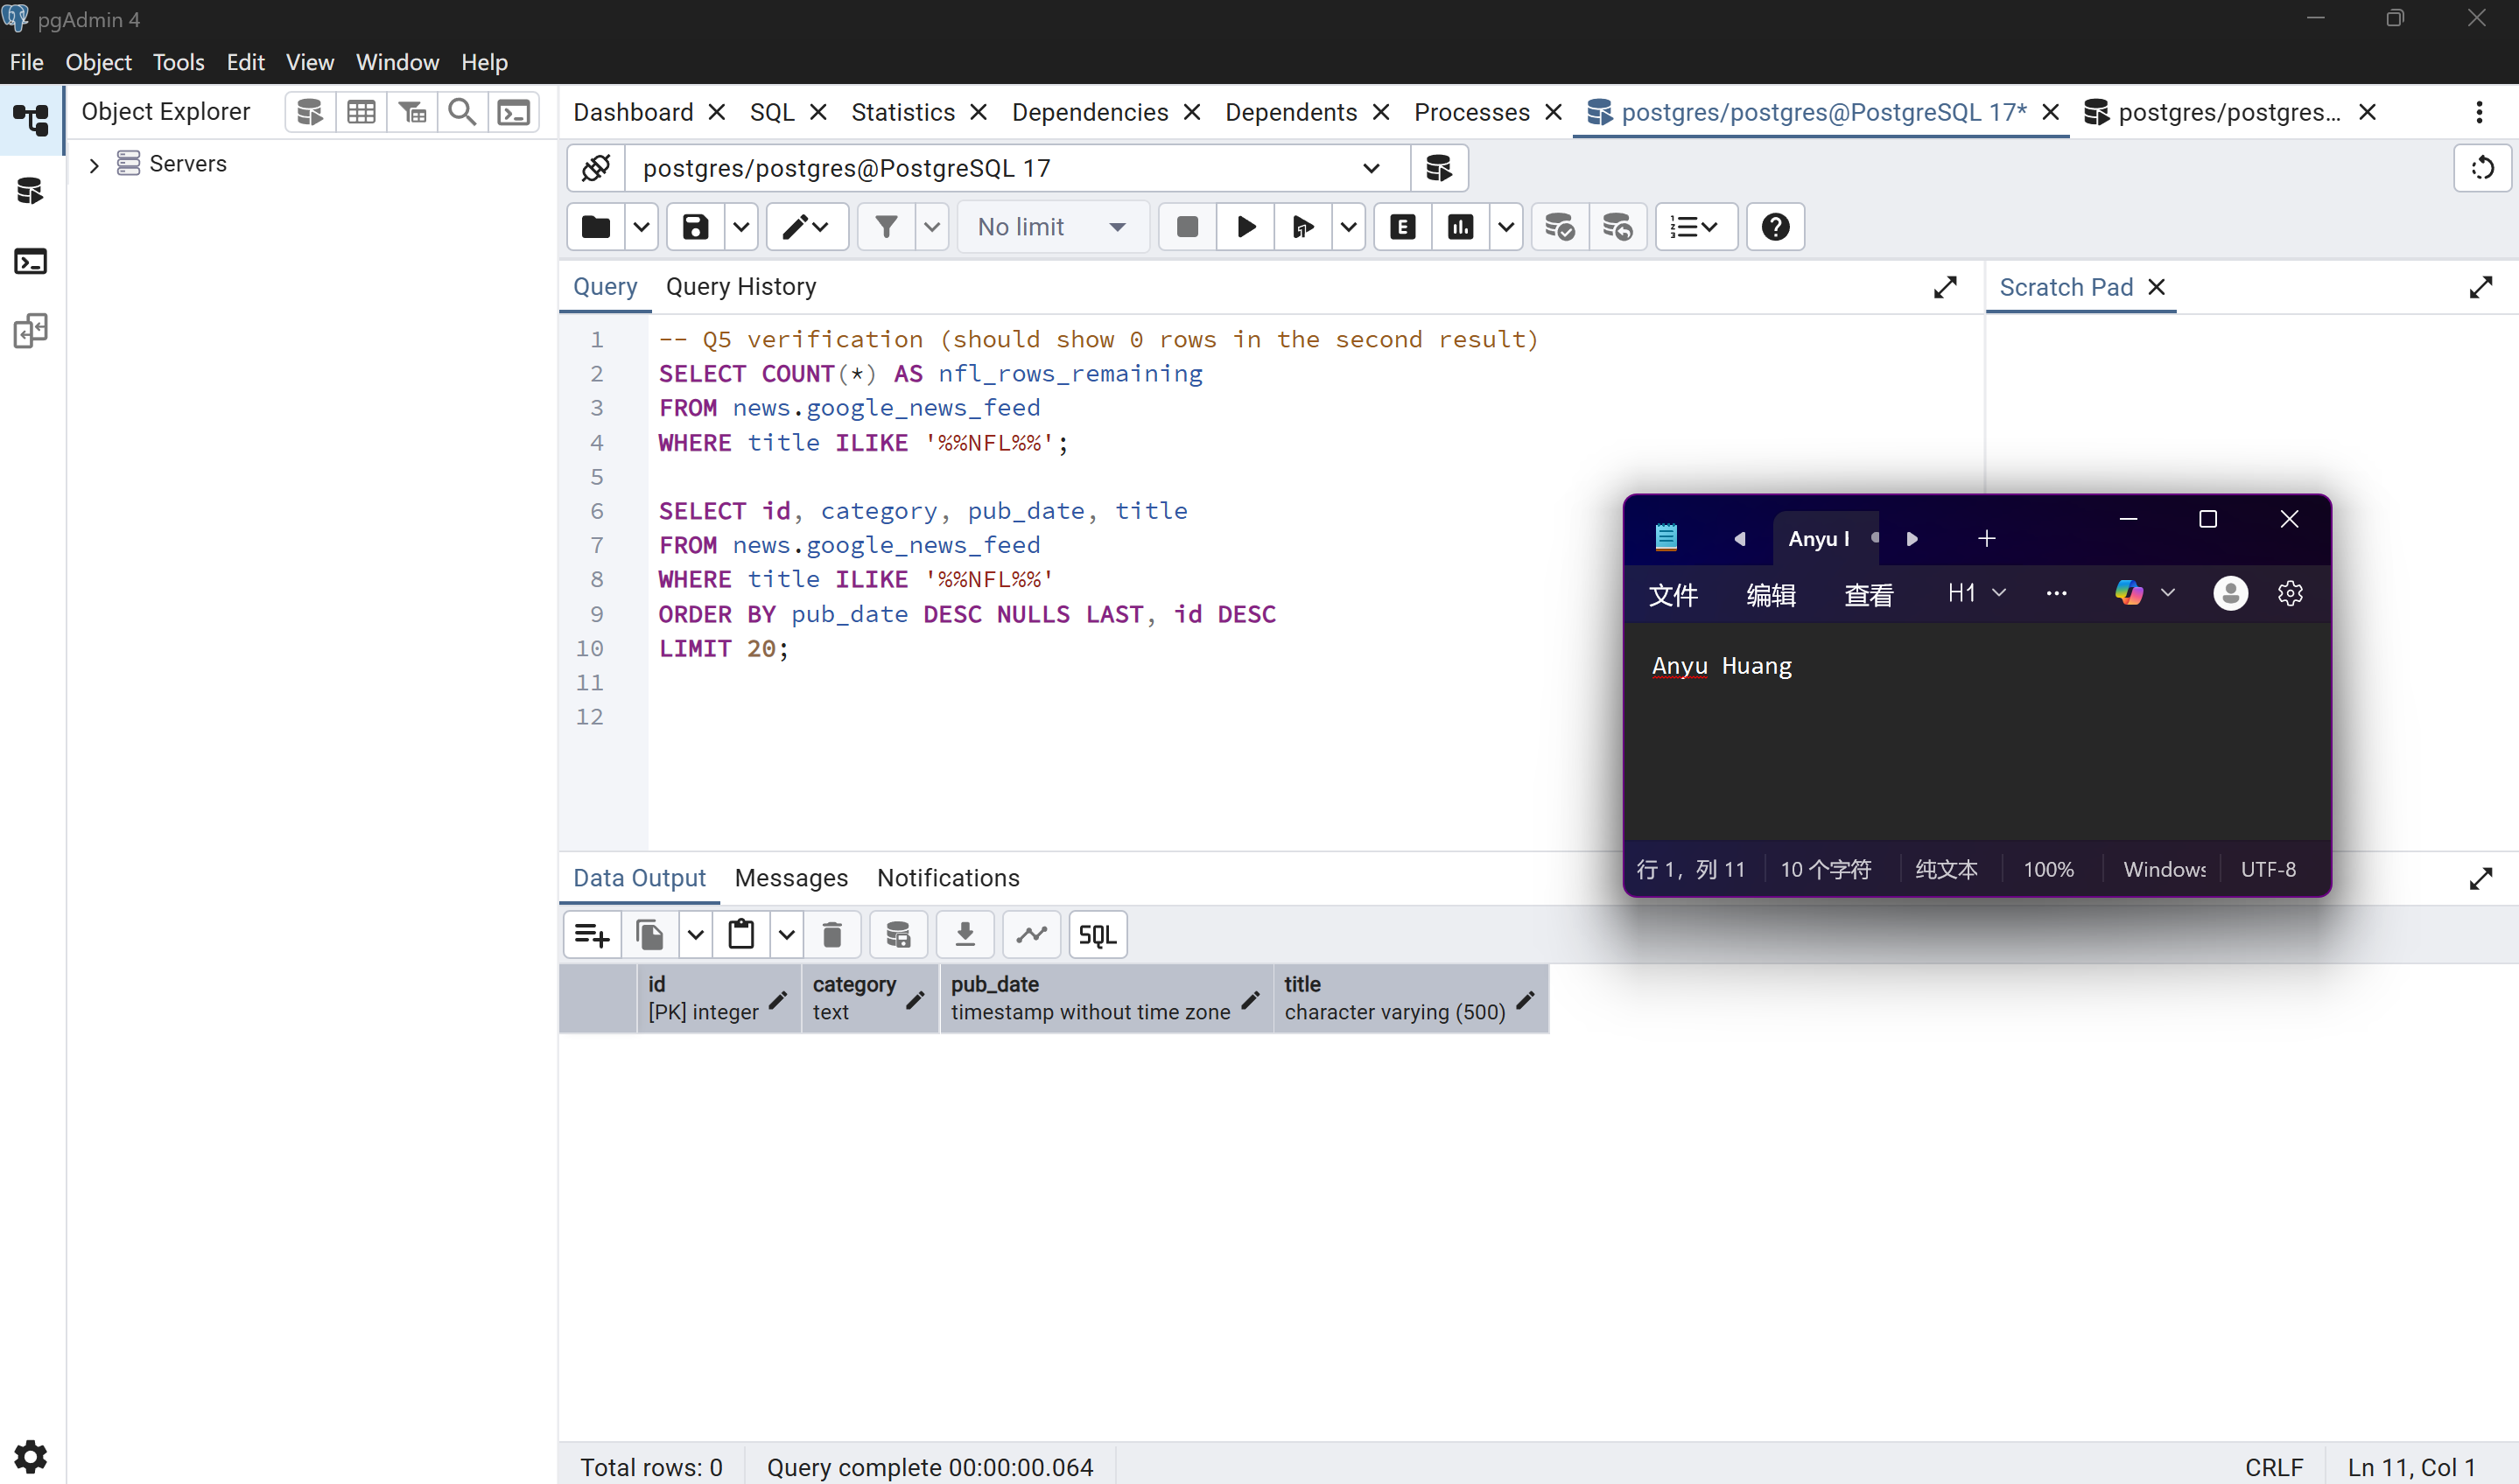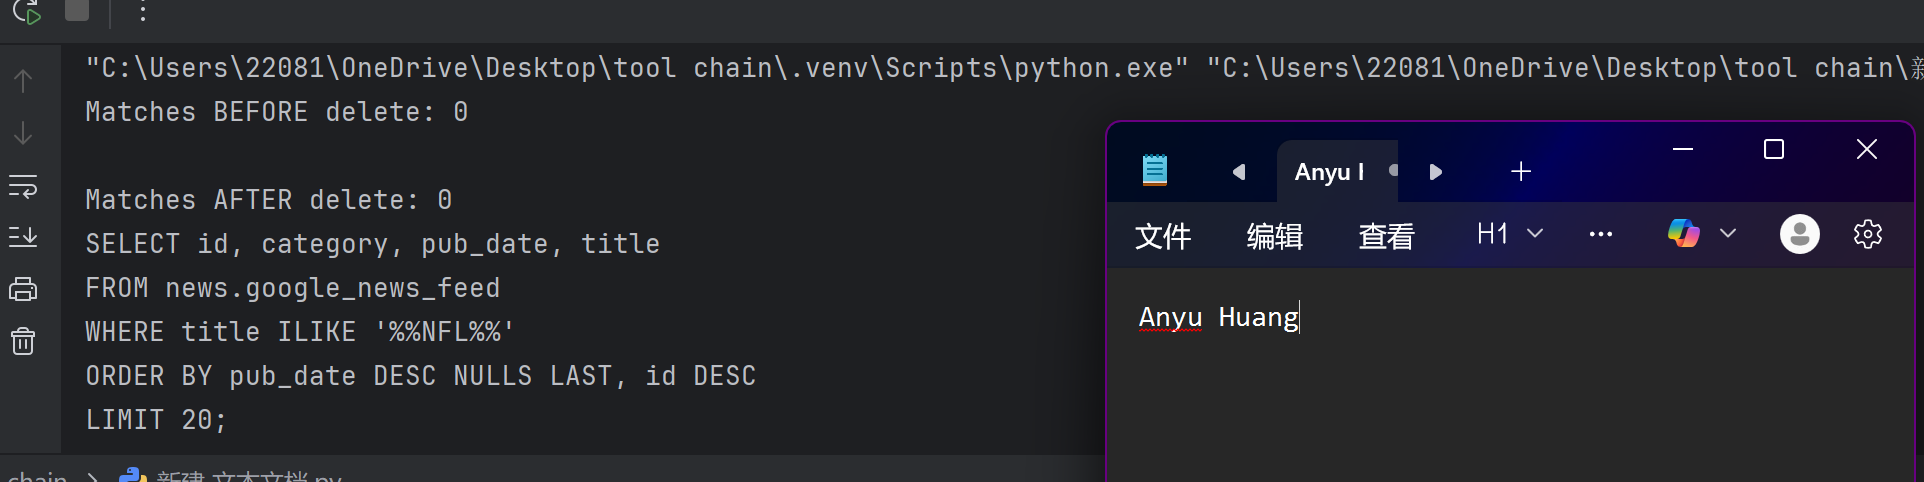

Q6：

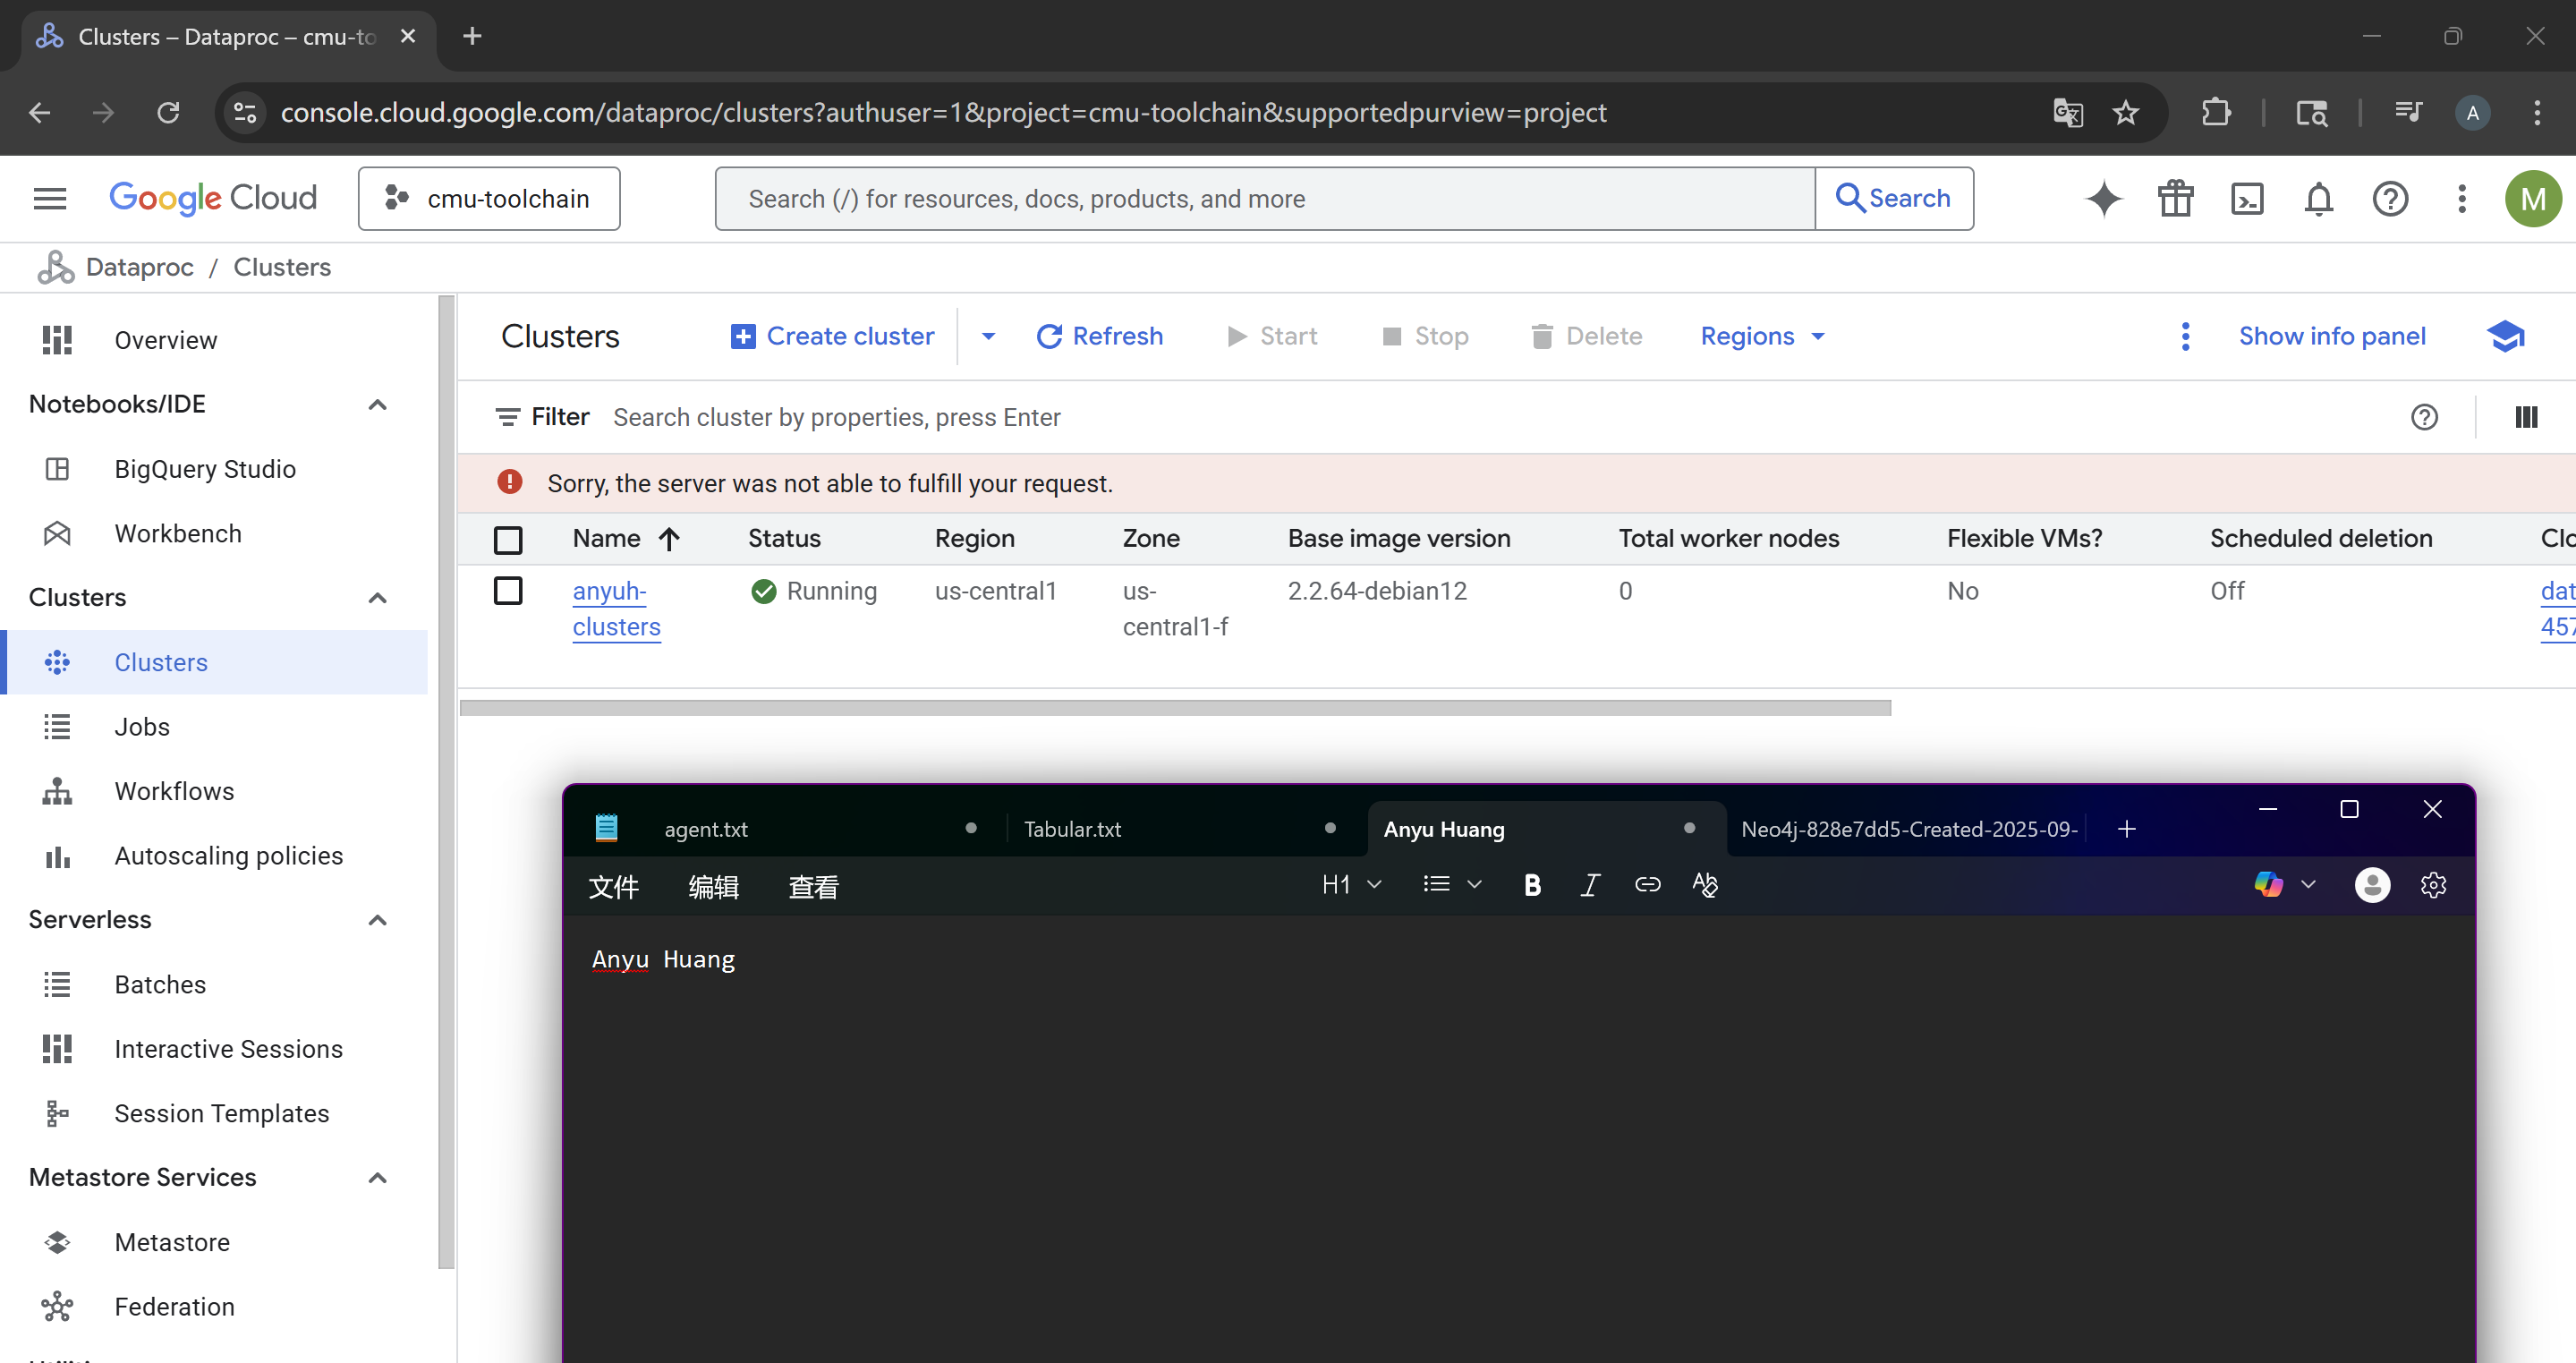